# pystan part 4 - hierarchical

- hierarchical  == multilevel
- `constituent model parameters are given probability models.`


In [26]:
%load_ext autoreload
%autoreload 2
import pystan
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
sns.set()
sns.set_context('notebook')
np.random.seed(111)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


( https://twiecki.io/blog/2014/03/17/bayesian-glms-3/)
(https://mc-stan.org/users/documentation/case-studies/radon.html)
(https://jrnold.github.io/bayesian_notes/multilevel-models.html)

- Radon, radioactive gas,  highest cause of lung cancer in non smokers
- it enters houses through the basements
- different types of soil , different concentrations
- measure across states, in every county
- focus on the state of Minnesota, county number: 85

## modeling radon levels in Minnesota

In [7]:
radon = pd.read_csv('../data/radon.csv')

In [27]:
radon.head()

,Unnamed: 0,idnum,state,state2,stfips,zip,region,typebldg,floor,room,...,pcterr,adjwt,dupflag,zipflag,cntyfips,county,fips,Uppm,county_code,log_radon
0,0,5081.0,MN,MN,27.0,55735,5.0,1.0,1.0,3.0,...,9.7,1146.499190,1.0,0.0,1.0,AITKIN,27001.0,0.502054,0,0.832909
1,1,5082.0,MN,MN,27.0,55748,5.0,1.0,0.0,4.0,...,14.5,471.366223,0.0,0.0,1.0,AITKIN,27001.0,0.502054,0,0.832909
2,2,5083.0,MN,MN,27.0,55748,5.0,1.0,0.0,4.0,...,9.6,433.316718,0.0,0.0,1.0,AITKIN,27001.0,0.502054,0,1.098612
3,3,5084.0,MN,MN,27.0,56469,5.0,1.0,0.0,4.0,...,24.3,461.623670,0.0,0.0,1.0,AITKIN,27001.0,0.502054,0,0.095310
4,4,5085.0,MN,MN,27.0,55011,3.0,1.0,0.0,4.0,...,13.8,433.316718,0.0,0.0,3.0,ANOKA,27003.0,0.428565,1,1.163151


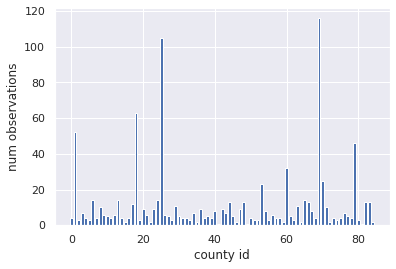

In [20]:
cf = [(k, len(v)) for k,v in radon.groupby("county_code")]
cf_x, cf_y = zip(*cf)
plt.bar(cf_x,cf_y)
plt.xlabel("county id")
plt.ylabel("num observations")
plt.show()

In [21]:
radon_subset = radon[['county', 'log_radon', 'floor']].head()

In [22]:
radon_subset

,county,log_radon,floor
0,AITKIN,0.832909,1.0
1,AITKIN,0.832909,0.0
2,AITKIN,1.098612,0.0
3,AITKIN,0.095310,0.0
4,ANOKA,1.163151,0.0


- `county`: county code
- `log radon`: log converted radon amount
- `floor`: whether the measurement was taken in the first floor (1) or on the basement.

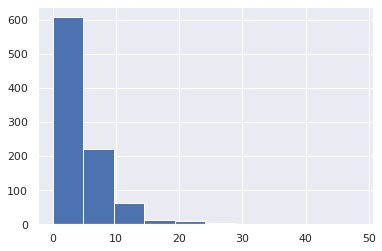

In [28]:
radon.activity.hist()

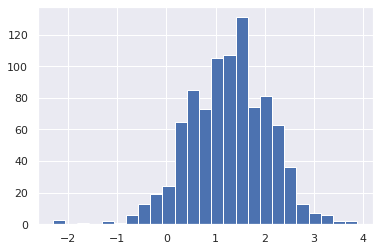

In [30]:
radon.activity.apply(lambda x: np.log(x+0.1)).hist(bins=25)

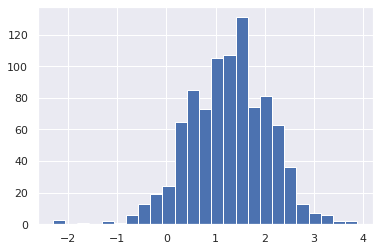

In [32]:
radon.log_radon.hist(bins=25)

## conventional modeling

- `complete pooling`: treat all counties the same, estimate a single radon level
    - $y_i = \alpha + \beta x_i +\epsilon_i$
- `no pooling`: model radon in *each* county independently
    - $y_i = \alpha_{j [i]} + \beta x_i +\epsilon_i $
    - $j = 1, ..., 85$




In [38]:
pooled = """
data {
  int<lower=0> N; // number of samples
  vector[N] x;   // floor or basement
  vector[N] y;   // log amount of radon measurements
}

parameters {
  vector[2] beta;  // beta 1 , beta 2  
  real<lower=0> sigma; // positive
} 

model {
  y ~ normal(beta[1] + beta[2] * x, sigma);
}

"""

In [34]:
# prepare data dict

log_radon = radon.log_radon.values
floor_measure = radon.floor.values

pooled_data_dict = {'N': len(log_radon),
               'x': floor_measure,
               'y': log_radon}


In [37]:
# floor_measure

In [39]:
# define stan model
pooled_fit = pystan.stan(
                model_code=pooled, 
                data=pooled_data_dict, 
                iter=1000, 
                chains=2)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_4d84a6c82b071fd0559ff7a0f68046b2 NOW.


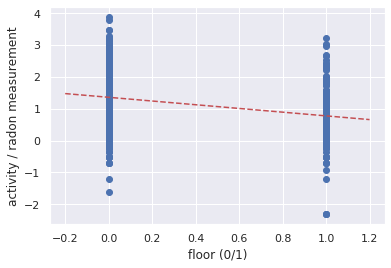

In [76]:
pooled_sample = pooled_fit.extract(permuted=True)
b0, m0 = pooled_sample['beta'].T.mean(1)
plt.scatter(radon.floor, np.log(radon.activity+0.1))
plt.xlabel("floor (0/1)")
plt.ylabel("activity / radon measurement")

xvals = np.linspace(-0.2, 1.2)
plt.plot(xvals, m0*xvals+b0, 'r--')


In [46]:
# now lets take a look at the unpooled way of modeling

unpooled_model = """data {
  int<lower=0> N; 
  int<lower=1,upper=85> county[N];  // explicitamente consideramos los counties
  vector[N] x;
  vector[N] y;
} 
parameters {
  vector[85] a; // vamos a obtener  one parameter per county
  real beta;
  real<lower=0,upper=100> sigma;
} 
transformed parameters {
  vector[N] y_hat;

  for (i in 1:N)
    y_hat[i] <- beta * x[i] + a[county[i]];  // transform ... 
}
model {
  y ~ normal(y_hat, sigma);
}"""



In [57]:
county = radon.county_code.values

unpooled_data = {'N': len(log_radon),
               'county': county+1, # Stan counts starting at 1
               'x': floor_measure,
               'y': log_radon}

In [78]:
#county

In [58]:
unpooled_fit = pystan.stan(
    model_code=unpooled_model, 
    data=unpooled_data, 
    iter=1000, 
    chains=2)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_25463b3705403e2328a8d1b377bb695b NOW.
To run all diagnostics call pystan.check_hmc_diagnostics(fit)


In [64]:
unpooled_fit['a'].shape

(1000, 85)

In [65]:
mn_counties = radon.county.unique()

unpooled_estimates = pd.Series(
    unpooled_fit['a'].mean(0), 
    index=mn_counties)

unpooled_se = pd.Series(
    unpooled_fit['a'].std(0), 
    index=mn_counties)

In [66]:
unpooled_estimates

AITKIN             0.889577
ANOKA              0.932220
BECKER             1.562948
BELTRAMI           1.596696
BENTON             1.427327
                     ...   
WATONWAN           2.722503
WILKIN             2.251701
WINONA             1.661959
WRIGHT             1.666429
YELLOW MEDICINE    1.208139
Length: 85, dtype: float64

In [67]:
unpooled_se

AITKIN             0.368026
ANOKA              0.102061
BECKER             0.410893
BELTRAMI           0.291866
BENTON             0.345850
                     ...   
WATONWAN           0.423173
WILKIN             0.713159
WINONA             0.204898
WRIGHT             0.193093
YELLOW MEDICINE    0.500892
Length: 85, dtype: float64

Text(0.5, 0, 'Ordered county')

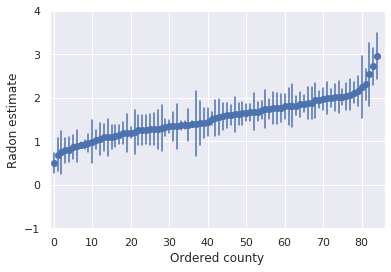

In [80]:
order = unpooled_estimates.sort_values().index

plt.xlim(-1,86)
plt.ylim(-1,4)

plt.scatter(
    range(len(unpooled_estimates)), 
    unpooled_estimates[order])

for i, m, se in zip(range(len(unpooled_estimates)), unpooled_estimates[order], unpooled_se[order]):
    plt.plot([i,i], [m-se, m+se], 'b-')

plt.ylabel('Radon estimate')
plt.xlabel('Ordered county')


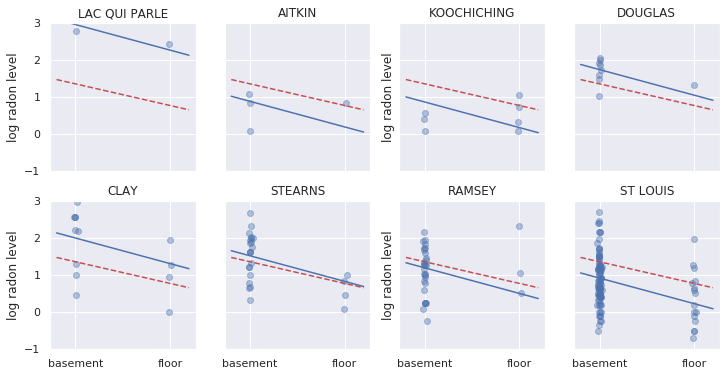

In [72]:
sample_counties = ('LAC QUI PARLE', 'AITKIN', 'KOOCHICHING', 
                    'DOUGLAS', 'CLAY', 'STEARNS', 'RAMSEY', 'ST LOUIS')

fig, axes = plt.subplots(2, 4, figsize=(12, 6), sharey=True, sharex=True)
axes = axes.ravel()
m = unpooled_fit['beta'].mean(0)

for i,c in enumerate(sample_counties):
    y = radon.log_radon[radon.county==c]
    x = radon.floor[radon.county==c]
    axes[i].scatter(x + np.random.randn(len(x))*0.01, y, alpha=0.4)
    
    # No pooling model
    b = unpooled_estimates[c]
    
    # Plot both models and data
    xvals = np.linspace(-0.2, 1.2)
    axes[i].plot(xvals, m*xvals+b)
    axes[i].plot(xvals, m0*xvals+b0, 'r--')
    axes[i].set_xticks([0,1])
    axes[i].set_xticklabels(['basement', 'floor'])
    axes[i].set_ylim(-1, 3)
    axes[i].set_title(c)
    if not i%2:
        axes[i].set_ylabel('log radon level')

# razon por la cual Hierarchical makes sense

Neither of these models are satisfactory:

- if we are trying to identify high-radon counties, pooling is useless
- we do not trust extreme unpooled estimates produced by models using few observations



# multilevel model

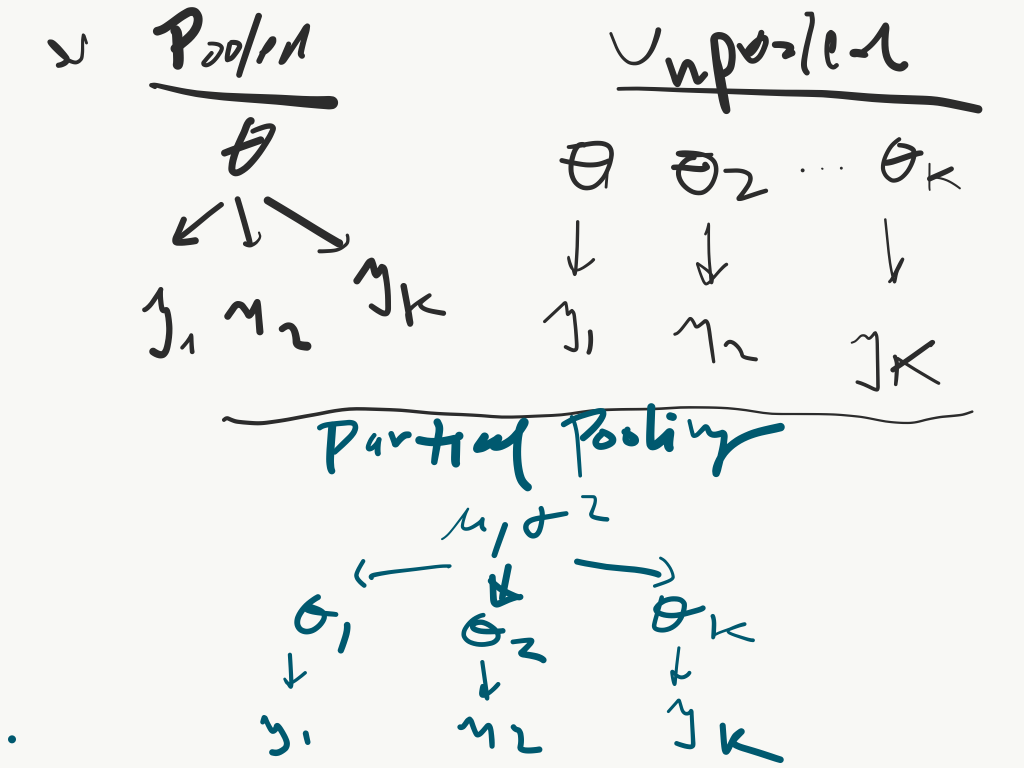

In [73]:
from IPython.display import Image
Image("1.png")

In [74]:
#En stan 

partial_pooling = """
data {
  int<lower=0> N; 
  int<lower=1,upper=85> county[N];
  vector[N] y;
} 
parameters {
  vector[85] a;
  real mu_a;
  real<lower=0,upper=100> sigma_a;   // two stds, one for the 
  real<lower=0,upper=100> sigma_y;   //
} 
transformed parameters {
  vector[N] y_hat;
  for (i in 1:N)
    y_hat[i] <- a[county[i]];
}
model {
  mu_a ~ normal(0, 1);
  a ~ normal (10 * mu_a, sigma_a);

  y ~ normal(y_hat, sigma_y);
}"""

